<a href="https://colab.research.google.com/github/LeuroPrince/Literature-Reproduction-for-WenLab/blob/main/Replicating_figure1_of_WenLab_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
file_path1c = "/content/drive/My Drive/WenLab/Figure 1-source data for Figure 1C and supplement 1A-B.xlsx"
df_fig1c = pd.read_excel(file_path1c, header = 2)

In [ ]:
df_fig1c.head()

,worm name,n,turn,no turn,no response,pause,Unnamed: 6,touching,no touching
0,Pmec-4_ChR2,674,322,272.0,79.0,1.0,NaN,283.0,39.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,reversal length,SEM,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2.58315,0.053253,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_raw1c = pd.read_excel(file_path1c,sheet_name = "Pmec-4_ChR2",header = 2)
df_raw1c.head()
df_raw1c['duration of reversal(s)'].fillna(0, inplace=True)#将no response 对应的值改为0

NameError: name 'pd' is not defined

In [ ]:
#我只关心有"turn"的和无"turn"，"no response"，"pause"的项的duration值，在此处将其选择出来
reversal_with_turn = df_raw1c[df_raw1c['turn?']== 1]['duration of reversal(s)']
reversal_without_turn = df_raw1c[df_raw1c['turn?']== 0]['duration of reversal(s)']
#定义no response项
no_response_mask = (df_raw1c['turn?'].isna()) & (df_raw1c['note'] == 'no res')
no_response = df_raw1c[no_response_mask]['duration of reversal(s)']
#定义pause项
pause_mask = (df_raw1c['turn?'].isna()) & (df_raw1c['note'] != 'no res')
pause = df_raw1c[pause_mask]['duration of reversal(s)']

#还要定义一个实验总数
total_num = len(df_raw1c)
print(" With Turn (n=" + str(len(reversal_with_turn)) + ") ")
print(reversal_with_turn.head())
print("\n")
print(" Without Turn (n=" + str(len(reversal_without_turn)) + ") ")
print(reversal_without_turn.head())
print("\n")
print(" no response (n=" + str(len(no_response)) + ") ")
print(no_response.head())
print(f"Pause: {len(pause)}")

--- With Turn (n=321) ---
1    3.149
2    3.649
3    4.769
7    2.028
8    3.286
Name: duration of reversal(s), dtype: float64


--- Without Turn (n=272) ---
4     3.255
5     3.239
6     2.665
10    1.937
11    2.801
Name: duration of reversal(s), dtype: float64


--- no response (n=79) ---
0     0.0
35    0.0
36    0.0
52    0.0
54    0.0
Name: duration of reversal(s), dtype: float64
Pause: 1


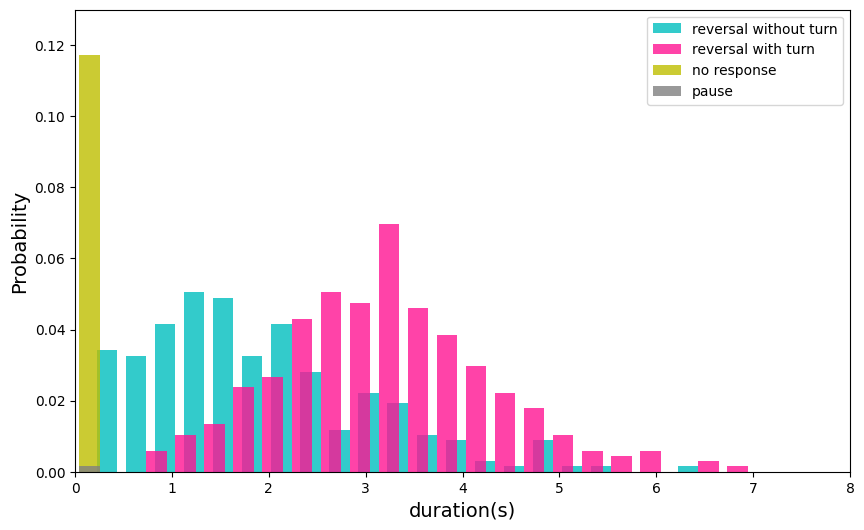

In [ ]:
bins = np.arange(0,8.5,0.3)
plt.figure(figsize=(10,6))
my_alpha = 0.8
rwidth = 0.7
offset1 = 0.00
offset2 = 0.09
offset3 = 0.18

bins1 = bins + offset1
bins2 = bins + offset2
bins3 = bins + offset3
# "without turn" 数据的权重
weights_with_turn = np.ones_like(reversal_with_turn) / total_num
# "without turn" 数据的权重
weights_without_turn = np.ones_like(reversal_without_turn) / total_num
#"no response"数据的权重
weights_no_response = np.ones_like(no_response) /total_num
#pause数据的权重
weights_pause = np.ones_like(pause) / total_num
plt.hist(reversal_without_turn, bins=bins3, weights=weights_without_turn,
         label='reversal without turn',
         color='c',
         alpha=my_alpha,
         rwidth=rwidth)

plt.hist(reversal_with_turn, bins=bins2, weights=weights_with_turn,
         label='reversal with turn',
         color='deeppink',
         alpha=my_alpha,
         rwidth=rwidth)

plt.hist(no_response, bins=bins1, weights=weights_no_response,
         label='no response',
         color='y',
         alpha=my_alpha,
         rwidth=rwidth)

plt.hist(pause, bins=bins1, weights=weights_pause,
         label='pause',
         color='gray',
         alpha=my_alpha,
         rwidth=rwidth)
plt.xlabel('duration(s)',fontsize = 14)
plt.ylabel('Probability',fontsize = 14)
plt.legend()
plt.ylim(0,0.13)
plt.xlim(0,8)
plt.show()

 曲线拟合成功！
  r1 (sigmoid) 拟合参数 (k1,k2,k3): [0.0938 0.895  3.6737]
  r2 (erfi) 拟合参数 (k1,k2,k3,k4): [0.0054 0.012  2.     0.5397]


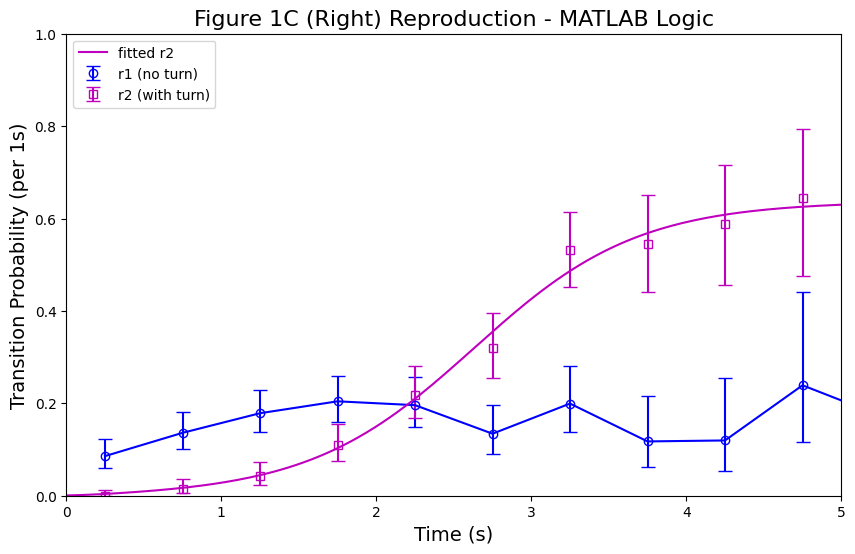

In [ ]:
###定义并绘画出拟合函数
from os import pipe2
from scipy.optimize import curve_fit
from scipy.special import erfi  # 导入 erfi (虚误差函数)
from statsmodels.stats.proportion import proportion_confint
import warnings
##fig1c(right)
#定义bins
bin_width = 0.5  #Δt = 0.5
max_time = np.ceil(max(reversal_with_turn.max(),reversal_without_turn.max()))
bins = np.arange(0, max_time+ bin_width, bin_width)

bin_starts = bins[:-1]
bin_centers = bin_starts + (bin_width/2)

#定义分子与分母的各项
  #用histogram命令选取每个bin中完成的reversal的个数
n_forward_i, _ = np.histogram(reversal_without_turn, bins=bins)
n_turn_i, _ = np.histogram(reversal_with_turn, bins=bins)
  #获得所有reversal的实验次数作为分母
total_reversals = pd.concat([reversal_with_turn, reversal_without_turn])

  #定义S_i，在这里我们要选取在bin=0.5s内的回退的次数，通过建立一个统计分布，我们就可以在任意选出的时间t，计算下一个t+bin的时刻发生转换的概率
S_i_total = []
for t_start in bin_starts:
  hit = np.sum(total_reversals >= t_start) #用了一个广播比较来输出S_i(通过把all_reversals中的每一个项与每一次取出来的t_starts比较，输出bool值，让后将True = 1，False = 0，求和)
  S_i_total.append(hit)

S_i_total = np.array(S_i_total)

##计算转换率r1和r2，这里我们根据matlab代码中的处理方法，把被除数从公式中的Δt*Si换为Si，因为我们是从离散的数据中来拟合公式的，只能用这种经验式的处理方法
p_r1 =np.divide(n_forward_i,S_i_total,
              out = np.zeros_like(n_forward_i,dtype = float),
              where=S_i_total!=0)
p_r2 =np.divide(n_turn_i,S_i_total,
              out = np.zeros_like(n_turn_i,dtype = float),
              where=S_i_total!=0)


##计算误差棒,定义概率的误差
err_forw_low_05, err_forw_high_05 = proportion_confint(n_forward_i, S_i_total, method='wilson')
err_turn_low_05, err_turn_high_05 = proportion_confint(n_turn_i, S_i_total, method='wilson')
##定义拟合函数
##r1用sigmod(inspired by matlab code )
def r1_func_fit(t,k1,k2,k3):
  return k1/(1+np.exp(-(t - k2))/k3)
##r2用erfi
def r2_func_fit(t,k1,k2,k3,k4):
  arg = k2+k3*np.exp(-t / k4)
  safe_arg = np.maximum(arg, 1e-9)##用来避免erfi(0)
  return k1 / erfi(safe_arg)
##拟合曲线（仔细问问这一段是如何实现的，意义是什么）
  ##拟合r1
k0_r1 = [0.3 ,3, 0.1]##一些初始猜测值 from matlab code
bounds_r1 = ([0, 0, 0.1], [1.0, 10.0, 5.0])##定义上界，下界
xdata_r1 = bin_centers[:11]
ydata_r1 = p_r1[:11]
popt_r1, _ = curve_fit(r1_func_fit, xdata_r1, ydata_r1,
                       p0=k0_r1, bounds=bounds_r1, maxfev=5000)
  ##拟合r2
k0_r2 = [0.0233, 0.1746, 0.7092, 0.2889]##来自matlab
bounds_r2 = ([0, 0, 0, 0.1], [1.0, 2.0, 2.0, 2.0]) # (下界), (上界)
xdata_r2 = bin_centers[:10]
ydata_r2 = p_r2[:10]
popt_r2, _ = curve_fit(r2_func_fit, xdata_r2, ydata_r2,
                     p0=k0_r2, bounds=bounds_r2, maxfev=5000)
print(" 曲线拟合成功！")
print(f"  r1 (sigmoid) 拟合参数 (k1,k2,k3): {np.round(popt_r1, 4)}")
print(f"  r2 (erfi) 拟合参数 (k1,k2,k3,k4): {np.round(popt_r2, 4)}")

##转换数据并绘图（这一步不太明白，也许作者希望使得数据更为直观？）
  ##定义一个转换函数
def convert_p05_to_p1(p):
  return 2*p - p**2
y_plot_r1_data = convert_p05_to_p1(p_r1)
y_plot_r2_data = convert_p05_to_p1(p_r2)
##转换误差棒
ci_forw_low_1s = convert_p05_to_p1(err_forw_low_05)
ci_forw_high_1s = convert_p05_to_p1(err_forw_high_05)
ci_turn_low_1s = convert_p05_to_p1(err_turn_low_05)
ci_turn_high_1s = convert_p05_to_p1(err_turn_high_05)
y_err_r1_low = np.abs(y_plot_r1_data - ci_forw_low_1s)
y_err_r1_high = np.abs(ci_forw_high_1s - y_plot_r1_data)
y_err_r2_low =np.abs(y_plot_r2_data - ci_turn_low_1s)
y_err_r2_high = np.abs(ci_turn_high_1s - y_plot_r2_data)
##转换拟合曲线
t_smooth = np.linspace(0,5,200)
##计算拟合曲线
fit_r1_p05s = r1_func_fit(t_smooth, *popt_r1)
fit_r2_p05s = r2_func_fit(t_smooth, *popt_r2)
##将计算出的拟合曲线进行转化
y_fit_r1_p1s = convert_p05_to_p1(fit_r1_p05s)
y_fit_r2_p1s = convert_p05_to_p1(fit_r2_p05s)

##绘图啦！
plt.figure(figsize=(10, 6))

# 绘制 r1 (no turn)
plt.errorbar(bin_centers, y_plot_r1_data, yerr=[y_err_r1_low, y_err_r1_high],
             fmt='bo', label='r1 (no turn)',
             markerfacecolor='none', capsize=5)

# 绘制 r2 (with turn)
plt.errorbar(bin_centers, y_plot_r2_data, yerr=[y_err_r2_low, y_err_r2_high],
             fmt='ms', label='r2 (with turn)',
             markerfacecolor='none', capsize=5)

# 绘制拟合曲线
plt.plot(bin_centers, y_plot_r1_data, 'b-', label='_nolegend_') # 蓝色实线
plt.plot(t_smooth, y_fit_r2_p1s, 'm-', label='fitted r2') # 粉色实线

# 美化图表
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Transition Probability (per 1s)', fontsize=14)
plt.title('Figure 1C (Right) Reproduction', fontsize=16)
plt.legend(loc='upper left')
plt.ylim(0, 1.0)
plt.xlim(0, 5)
plt.grid(False) # 关闭网格

plt.show()

In [ ]:
file_path1d = "/content/drive/My Drive/WenLab/Figure 1-source data for Figure 1D.xlsx"
df_fig1d = pd.read_excel(file_path1d, header =2)

In [ ]:
df_fig1d.head()

,turn,reversal duration,date
0,0,1.735,"2018,0505+2018,0519"
1,0,2.093,NaN
2,1,2.371,NaN
3,1,2.412,NaN
4,1,2.887,NaN


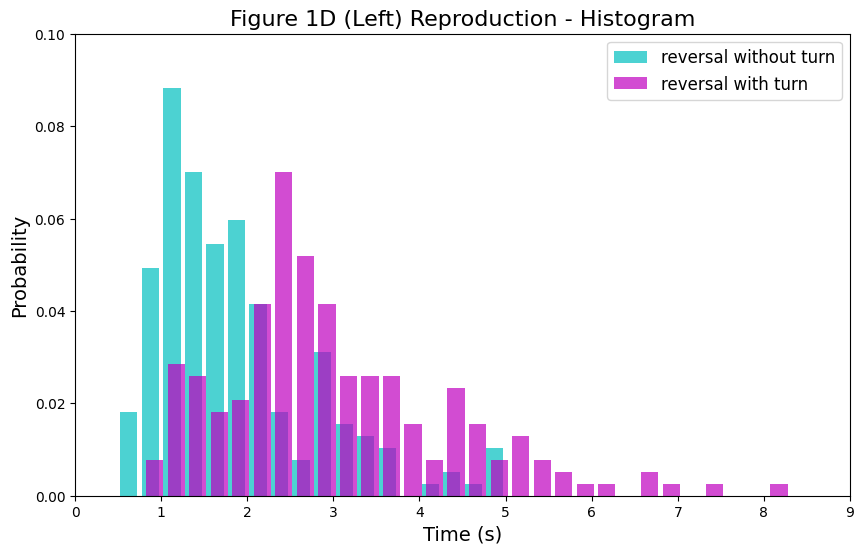

In [ ]:
##重命名列名以便代码复用，在这段代码里用与1c中不同的变量命名规则，如bin_rate会在命名中加入其功能以区分上述变量名
df_fig1d = df_fig1d.rename(columns={'turn': 'turn?', 'reversal duration': 'duration of reversal(s)'})
##复用fig1c中的代码，清洗数据，进行分类
reversal_with_turn_1d = df_fig1d[df_fig1d['turn?'] == 1]['duration of reversal(s)']
reversal_without_turn_1d = df_fig1d[df_fig1d['turn?'] == 0]['duration of reversal(s)']
total_trials_1d = len(df_fig1d)
##该做直方图了
bins_hist = np.arange(0,9.5,0.25)
bin_offset = 0.05

weights_with_1d = np.ones_like(reversal_with_turn_1d) / total_trials_1d
weights_without_1d = np.ones_like(reversal_without_turn_1d) / total_trials_1d

plt.figure(figsize=(10, 6))
my_alpha_hist = 0.7
my_rwidth_hist = 0.8

plt.hist(reversal_without_turn_1d,bins=bins_hist,weights=weights_without_1d,
         label='reversal without turn',
         color = 'c',
         alpha = my_alpha_hist,
         rwidth = my_rwidth_hist)
plt.hist(reversal_with_turn_1d, bins=bins_hist + bin_offset, weights=weights_with_1d,
         label='reversal with turn',
         color='m',
         alpha=my_alpha_hist,
         rwidth = my_rwidth_hist)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.title('Figure 1D (Left) Reproduction - Histogram', fontsize=16)
plt.ylim(0, 0.1) # Y 轴范围与论文一致
plt.xlim(0, 9)   # X 轴范围与论文一致
plt.show()

# 在这里复现的图像与原文的图像总是不一致，在这里我猜测对于bin的选择不同会导致图像呈现出不同的样貌。
# 但是我认为这种方式是可以忠实的表达我们想要展现的趋势，即reversal without turn倾向于快速结束，
# 而Ω turn前往往会伴随更长的reversal时期。故在此选择对这个图像进行保留于讨论

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)


Figure 1D r2 曲线拟合成功！
  r2 (erfi) 拟合参数 (k1,k2,k3,k4): [1.000e-04 3.000e-04 2.291e-01 3.083e-01]


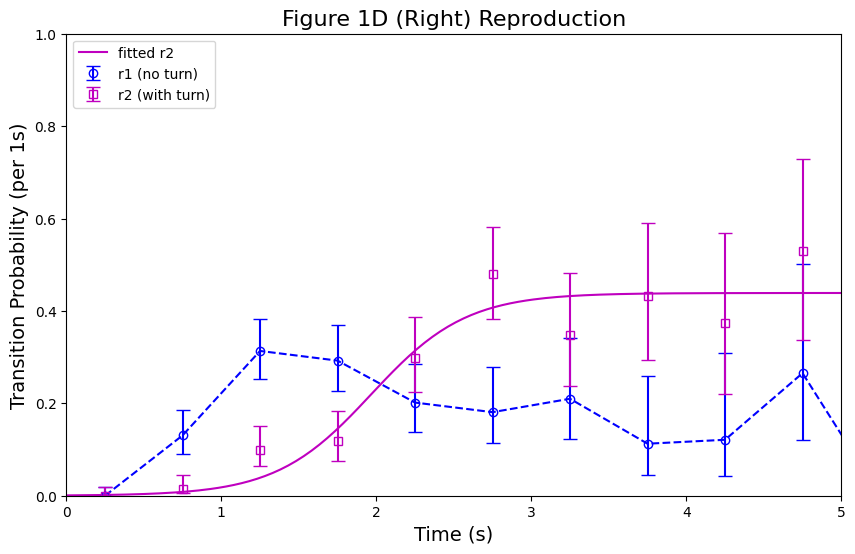

In [ ]:
##开始绘制1D的右图
bin_width = 0.5
max_time_data_1d = max(reversal_without_turn_1d.max(), reversal_with_turn_1d.max())
max_time_bins_1d = np.ceil(max(max_time_data_1d, 5.5)) # 确保至少到 5.5s
bins_rate = np.arange(0, max_time_bins_1d + bin_width, bin_width)
##计算n_i
n_forw_i_1d, _ = np.histogram(reversal_without_turn_1d, bins=bins_rate)
n_turn_i_1d, _ = np.histogram(reversal_with_turn_1d, bins=bins_rate)

##S_total_i
all_reversals_1d = pd.concat([reversal_with_turn_1d, reversal_without_turn_1d])
bin_starts_rate = bins_rate[:-1]
S_total_i_1d = np.array([np.sum(all_reversals_1d >= t_start) for t_start in bin_starts_rate])
# 确保长度一致
S_total_i_1d = S_total_i_1d[:len(n_forw_i_1d)]
##计算每0.5s的bin内reversals终止的概率p_05及其置信区间
p_forw_05s_1d = np.divide(n_forw_i_1d, S_total_i_1d, out=np.zeros_like(n_forw_i_1d, dtype=float), where=S_total_i_1d!=0)
p_turn_05s_1d = np.divide(n_turn_i_1d, S_total_i_1d, out=np.zeros_like(n_turn_i_1d, dtype=float), where=S_total_i_1d!=0)

ci_forw_low_05s_1d, ci_forw_high_05s_1d = proportion_confint(n_forw_i_1d, S_total_i_1d, method='wilson')
ci_turn_low_05s_1d, ci_turn_high_05s_1d = proportion_confint(n_turn_i_1d, S_total_i_1d, method='wilson')
##定义拟合函数

def r2_func_matlab(t, k1, k2, k3, k4):
    arg = k2 + k3 * np.exp(-t / k4)
    safe_arg = np.maximum(arg, 1e-9)
    return k1 / erfi(safe_arg)

bin_centers_rate = bin_starts_rate + (bin_width / 2)
k0_r2_1d = [0.02, 0.1, 0.7, 0.3] # 调整后的初始值
bounds_r2_1d = ([0, 0, 0, 0.1], [1.0, 2.0, 2.0, 5.0])

num_points_r2_1d = 10
xdata_r2_1d = bin_centers_rate[:num_points_r2_1d]
ydata_r2_1d = p_turn_05s_1d[:num_points_r2_1d]
# 处理可能的 NaN 值
valid_indices_r2_1d = ~np.isnan(ydata_r2_1d) & (S_total_i_1d[:num_points_r2_1d] > 0) # 确保有幸存者

if np.any(valid_indices_r2_1d): # 只有在有有效数据点时才拟合
    popt_r2_1d, _ = curve_fit(r2_func_matlab, xdata_r2_1d[valid_indices_r2_1d], ydata_r2_1d[valid_indices_r2_1d],
                         p0=k0_r2_1d, bounds=bounds_r2_1d, maxfev=5000)
    print("Figure 1D r2 曲线拟合成功！")
    print(f"  r2 (erfi) 拟合参数 (k1,k2,k3,k4): {np.round(popt_r2_1d, 4)}")
    fit_successful_1d = True
else:
    print("没有足够的有效数据点来拟合 Figure 1D 的 r2 曲线。")
    fit_successful_1d = False

##进行transfer并绘制图像
def convert_p05_to_p1(p):
    p_safe = np.nan_to_num(p) # 处理 NaN
    return 2 * p_safe - p_safe**2

# 转换 Y 轴数据点 (确保长度与 bin_centers_rate 匹配)
num_points_plot_1d = len(bin_centers_rate)
y_plot_r1_data_1d = convert_p05_to_p1(p_forw_05s_1d[:num_points_plot_1d])
y_plot_r2_data_1d = convert_p05_to_p1(p_turn_05s_1d[:num_points_plot_1d])

# 转换误差棒大小 (确保长度一致)
ci_forw_low_1s_1d = convert_p05_to_p1(ci_forw_low_05s_1d[:num_points_plot_1d])
ci_forw_high_1s_1d = convert_p05_to_p1(ci_forw_high_05s_1d[:num_points_plot_1d])
ci_turn_low_1s_1d = convert_p05_to_p1(ci_turn_low_05s_1d[:num_points_plot_1d])
ci_turn_high_1s_1d = convert_p05_to_p1(ci_turn_high_05s_1d[:num_points_plot_1d])
y_err_r1_low_1d = np.abs(y_plot_r1_data_1d - ci_forw_low_1s_1d)
y_err_r1_high_1d = np.abs(ci_forw_high_1s_1d - y_plot_r1_data_1d)
y_err_r2_low_1d = np.abs(y_plot_r2_data_1d - ci_turn_low_1s_1d)
y_err_r2_high_1d = np.abs(ci_turn_high_1s_1d - y_plot_r2_data_1d)

# 生成 r2 的平滑拟合曲线 (仅在拟合成功时)
t_smooth = np.linspace(0, 5, 200)
if fit_successful_1d:
    fit_line_r2_p05s_1d = r2_func_matlab(t_smooth, *popt_r2_1d)
    y_plot_r2_line_1d = convert_p05_to_p1(fit_line_r2_p05s_1d)

#  绘制最终图表
plt.figure(figsize=(10, 6))
# 绘制 r1 (no turn) 数据点和误差棒
plt.errorbar(bin_centers_rate, y_plot_r1_data_1d, yerr=[y_err_r1_low_1d, y_err_r1_high_1d],
             fmt='bo', label='r1 (no turn)',
             markerfacecolor='none', capsize=5)
# 用折线连接 r1 数据点
plt.plot(bin_centers_rate, y_plot_r1_data_1d, 'b--', label='_nolegend_')

# 绘制 r2 (with turn) 数据点和误差棒
plt.errorbar(bin_centers_rate, y_plot_r2_data_1d, yerr=[y_err_r2_low_1d, y_err_r2_high_1d],
             fmt='ms', label='r2 (with turn)',
             markerfacecolor='none', capsize=5)

# 绘制 r2 的平滑拟合曲线 (仅在拟合成功时)
if fit_successful_1d:
    plt.plot(t_smooth, y_plot_r2_line_1d, 'm-', label='fitted r2')

# 美化图表
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Transition Probability (per 1s)', fontsize=14)
plt.title('Figure 1D (Right) Reproduction', fontsize=16)
plt.legend(loc='upper left')
plt.ylim(0, 1.0)
plt.xlim(0, 5) # 限制 X 轴范围与论文一致
plt.grid(False)
plt.show()